In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import ipy_utils
import numpy as np
import pandas as pd
from scipy.stats import cumfreq

/Users/nicochaves/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [10]:
results_dir = 'Results/full_results_1_tissue_loss_l2_neg_0/'

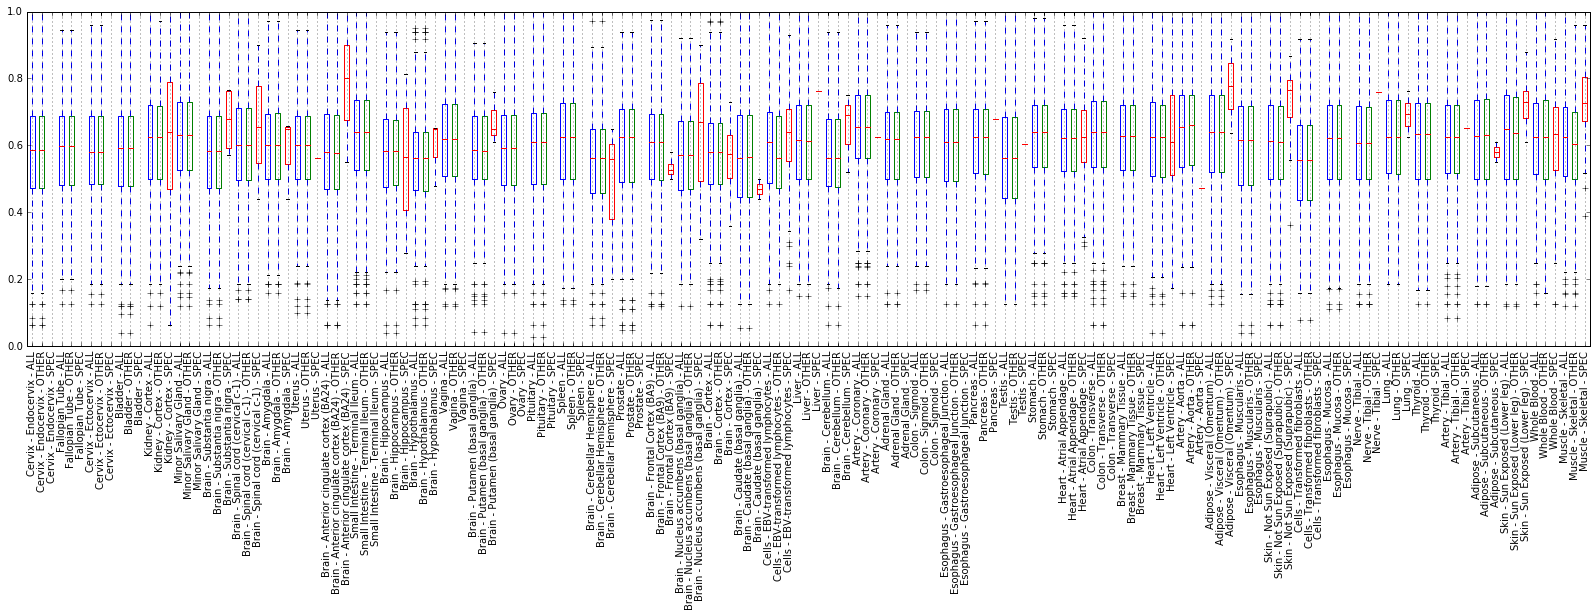

In [13]:
# Get all GO terms   
inputFilename = '../data/GO_terms_final_gene_counts.txt'
GO_list_file = open(inputFilename)
GO_list = np.loadtxt(GO_list_file,skiprows=2,usecols=[0],dtype='S10',delimiter='\t')

all_tissues = ipy_utils.get_tissue_list('../data/tissues.txt')
GTEX_to_GO = ipy_utils.map_GTEX_to_GO(ipy_utils.map_GO_to_GTEX())

# Sort order by number of samples
GTEX_to_cols = ipy_utils.map_GTEX_to_cols('../data/tissue_metadata/', all_tissues)
num_samples = [len(GTEX_to_cols[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_samples) # sort in order

# Make tripled labels
labels = np.array(all_tissues)[index_order]
all_labels = np.array([[label + ' - ALL',label + ' - OTHER',label + ' - SPEC'] for label in labels])
all_labels = all_labels.flatten()

aucs_spec = [[] for tissue in all_tissues]
aucs_other = [[] for tissue in all_tissues]
aucs_all = [[] for tissue in all_tissues]

for i,tissue in enumerate(labels):
    
    terms = GTEX_to_GO[tissue]
    for GO in GO_list:
        file_name = results_dir + GO + '_neg_0/'
        auc = ipy_utils.get_1_tissue_aucs(GO, [tissue], file_name)
        aucs_all[i] = np.append(aucs_all[i],auc)
        if GO in terms:
            aucs_spec[i] = np.append(aucs_spec[i],auc)
        else:
            aucs_other[i] = np.append(aucs_other[i],auc)

full_spec = []
full_other = []
full_all = []
for i in range(len(all_tissues)):
    full_all.append(aucs_all[i])
    full_all.append([])
    full_all.append([])
    full_other.append([])
    full_other.append(aucs_other[i])
    full_other.append([])
    full_spec.append([])
    full_spec.append([])
    full_spec.append(aucs_spec[i])


plt.figure(figsize=(28,6))
plt.margins(0.01)
plt.ylim([0,1])
ax = plt.gca()
ax.xaxis.grid(which='both')
plt.xticks(range(len(all_labels)), all_labels, rotation='vertical')

box_all = ax.boxplot(full_all,labels=all_labels)
for patch in box_all['boxes']:
    patch.set_color('blue')

box_spec = ax.boxplot(full_spec, labels=all_labels)
for patch in box_spec['boxes']:
    patch.set_color('red')

box_other = ax.boxplot(full_other, labels=all_labels)
for patch in box_other['boxes']:
    patch.set_color('green')

plt.show()

# In the plot below, each tissue has three columns. The blue column shows boxplot of AUC scores on all GO terms,
# as predicted by this tissue. The green column shows boxplot of AUC scores on all NON-associated GO terms,
# as predicted by this tissue. The red column shows boxplot of AUC scores on all GO terms associate with this tissue,
# as predicted by this tissue.
# Note that many tissues lack a red column. These have no associated GO terms. They may also only have one, in which
# case there is a line, but no box.

In [14]:
GO_terms = ipy_utils.get_go_terms()
all_tissues = ipy_utils.get_tissue_list('../data/tissues.txt')
results_dir = 'Results/full_results_1_tissue_loss_l2_neg_0'
aucs = ipy_utils.get_all_1_tissue_aucs(GO_terms, all_tissues, results_dir)

In [15]:
GO_to_GTEX = ipy_utils.map_GO_to_GTEX()
GTEX_to_GO = ipy_utils.map_GTEX_to_GO(GO_to_GTEX)

## AUC Score Distribution Using Features from Individual Tissues (Tissues not ordered)

Observations: 
1. There is no single tissue that is overfitting most of the GO terms (specific or nonspecific to itself)
2. The variance of the performance of each tissue is high across all GO terms, possibly because of the lack of specificity.

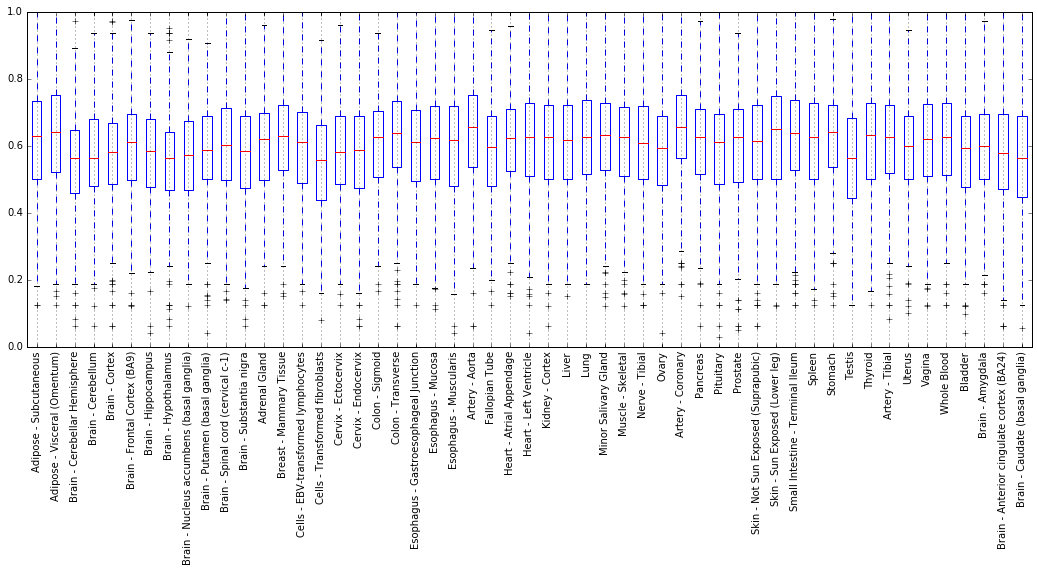

In [16]:
ipy_utils.make_boxplot(aucs, all_tissues)

## Sort tissues by number of Samples

Observations: 
1. Tissues with more samples do not seem to overfit significantly to all GO terms in general.
2. The variance of the performance of each tissue is high across all GO terms, possibly because of the lack of specificity.

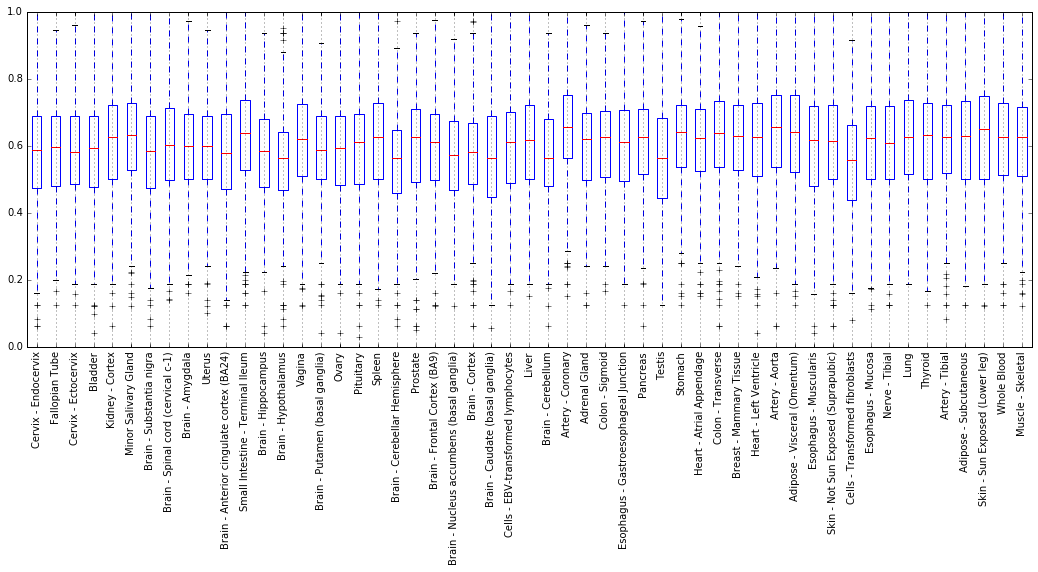

In [17]:
GTEX_to_cols = ipy_utils.map_GTEX_to_cols('../data/tissue_metadata/', all_tissues)
num_samples = [len(GTEX_to_cols[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_samples) # sort in order
tissues_sorted_samp = np.array(all_tissues)[index_order]
aucs_sorted_samp = np.transpose(np.transpose(aucs)[index_order])

ipy_utils.make_boxplot(aucs_sorted_samp, tissues_sorted_samp)

## Sort tissues by number of GO terms

Observations: 
1. Tissues associated with more GO terms do not necessarily do better in the presence of unrelated GO terms.
2. The variance of the performance of each tissue is high across all GO terms, possibly because of the lack of specificity.

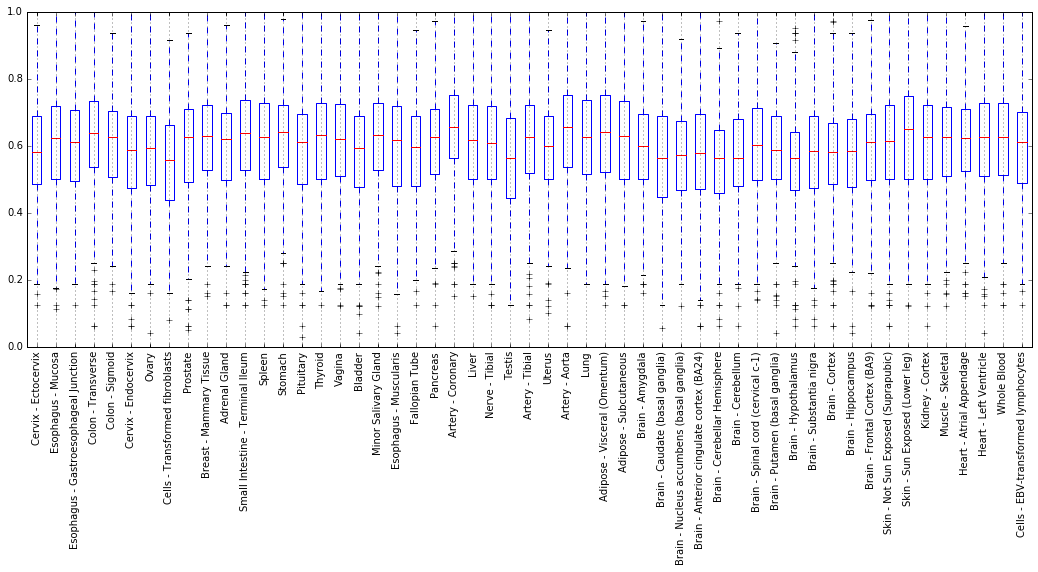

In [18]:
num_GO = [len(GTEX_to_GO[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_GO) # sort in order
tissues_sorted_GO = np.array(all_tissues)[index_order]
aucs_sorted_GO = np.transpose(np.transpose(aucs)[index_order])

ipy_utils.make_boxplot(aucs_sorted_GO, tissues_sorted_GO)

## AUC Distributions using only those GO terms specific to the tissue (sort by # GO terms)

Observations: 
1. Some tissues (such Brain and Skin) show high specificity.
2. Tissues associated with many GO terms (Cells, Whole Blood and Heart) have very high variability (maybe due to the fact that the samples associated with this tissue is heterogenous to start with or the annotation of the GO terms is highly variable)

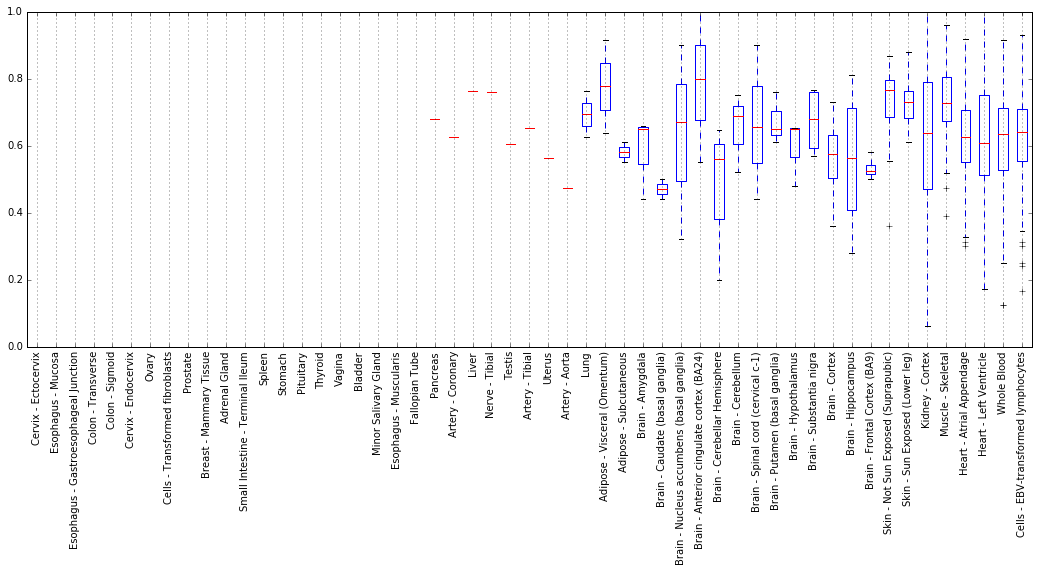

In [19]:
# For each tissue, get the AUC of each GO term that is associated with it.
aucs_spec = []
for tissue in all_tissues:
    terms = GTEX_to_GO[tissue]
    aucs_spec.append(ipy_utils.get_all_1_tissue_aucs(terms, [tissue], results_dir))
    
# Sort tissues by number of GO terms
num_GO = [len(GTEX_to_GO[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_GO) # sort in order
tissues_sorted = np.array(all_tissues)[index_order]
aucs_spec_sorted = np.array(aucs_spec)[index_order]
   
ipy_utils.make_boxplot(aucs_spec_sorted, tissues_sorted)

## AUC Distributions using only those GO terms specific to each tissue (sort tissues by # GO terms)

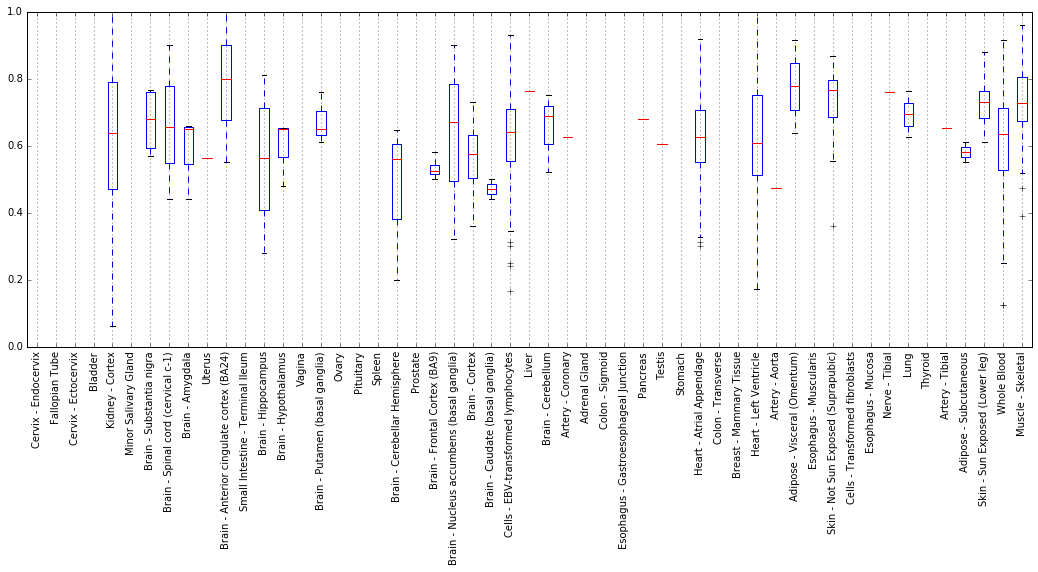

In [20]:
GTEX_to_cols = ipy_utils.map_GTEX_to_cols('../data/tissue_metadata/', all_tissues)
num_samples = [len(GTEX_to_cols[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_samples) # sort in order
tissues_spec_sorted_samp = np.array(all_tissues)[index_order]
aucs_spec_sorted_samp = np.transpose(np.transpose(aucs_spec)[index_order])

ipy_utils.make_boxplot(aucs_spec_sorted_samp, tissues_spec_sorted_samp)

In [22]:
def get_emp_cdf(arr, num_bins=53):
    # Get the empirical CDF of |arr|
    cumfreqs, _, _, _ = cumfreq(arr, num_bins, defaultreallimits=(0,num_bins+0.1))
    return (1.0 / arr.shape[1]) * cumfreqs  # Normalize the frequencies so that the max is 1


def plot_emp_cdf(auc_array, tissues, GO_terms, tissue_heats, colorbar_label, hmap_normalization=1,
                 special_tissues=[], special_tissue_color='green',
                 tissue_specific_GO=False, gtex_to_go_map=None):

    if tissue_specific_GO:
        # For each tissue, only consider its AUC ranking for associated GO terms
        assoc_rows = []  # rows of GO terms associated w/each tissue
        for i, tissue in enumerate(tissues):
            cur_assoc_rows = []  # rows of GO terms associated w/this tissue
            for term in gtex_to_go_map[tissue]:
                cur_assoc_rows.append(GO_terms.index(term))
            assoc_rows.append(sorted(cur_assoc_rows))

    # Generate the heatmap using the |tissue_heats| parameter
    cmap = plt.cm.YlOrRd
    min_val = min(tissue_heats)
    max_val = max(tissue_heats) / (1.0 * hmap_normalization)
    scalarMap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_val, vmax=max_val))

    num_tissues = len(tissues)
    num_GO_terms = auc_array.shape[0]

    plt.figure(figsize=(18, 6))
    ax = plt.gca()
    plt.ylim([0,1])
    plt.xlim([1, num_tissues])

    for i, tissue in enumerate(tissues):

        if tissue_specific_GO:
            cur_assoc_rows = assoc_rows[i]  # Row indexes of GO terms associated with this tissue
            if len(cur_assoc_rows) == 0:
                continue
                tissue_rankings = np.zeros(shape=(1,len(assoc_rows)))
            tissue_rankings = np.zeros(shape=(1,len(cur_assoc_rows)))
        else:
            tissue_rankings = np.zeros(shape=(1,num_GO_terms))

        idx = 0
        for j, row in enumerate(auc_array): # for each GO term
            if tissue_specific_GO and j not in cur_assoc_rows:
                continue
            cur_auc = row[i]  # ith tissue's AUC score for this GO term
            cur_ranking = 1 + sum(a > cur_auc for a in row)
            tissue_rankings[0,idx] = cur_ranking
            idx += 1

        emp_cdf = get_emp_cdf(tissue_rankings, num_bins=num_tissues)
        if tissue in special_tissues:
            colorVal = 'green'
        else:
            colorVal = scalarMap.to_rgba(tissue_heats[i])
        ax.plot(range(1,num_tissues+1), emp_cdf, color=colorVal)

    # Generate colorbar
    scalarMap.set_array([])  # You have to set a dummy-array for this to work...
    cbar = plt.colorbar(scalarMap)
    cbar.set_label(colorbar_label)

    ax.set_xlabel('# of Tissues')
    ax.set_ylabel('% of GO Terms')
    ax.grid()
    plt.show()

    if len(special_tissues) > 0:
        print 'Highlighted tissues: ', ', '.join(special_tissues)
    return

In [23]:
# Get # of GO terms and samples for each tissue. Use these counts for heatmaps
GO_counts = [len(GTEX_to_GO[tissue]) for tissue in all_tissues]
GTEX_to_cols = ipy_utils.map_GTEX_to_cols('../data/tissue_metadata/', all_tissues)
sample_counts = [len(GTEX_to_cols[tissue]) for tissue in all_tissues]

special_tissues = []
thresh = 60  # number of GO terms for a tissue to be "special"
for i, tissue in enumerate(all_tissues):
    if len(GTEX_to_GO[tissue]) > thresh:
        special_tissues.append(tissue)

## "CDF" Curves. Ex: For X% of GO terms associated with a given tissue (e.g. blood), that tissue's features are in the top N AUC Scores.

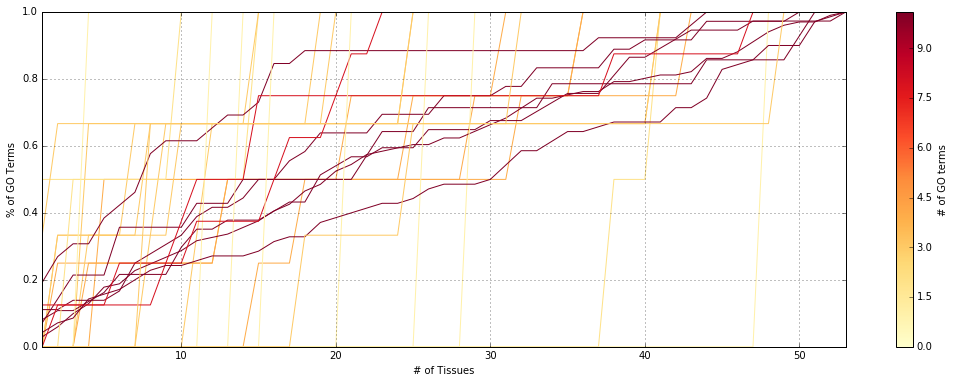

In [24]:
plot_emp_cdf(aucs, all_tissues, GO_terms, GO_counts, '# of GO terms', hmap_normalization=10, tissue_specific_GO=True, gtex_to_go_map=GTEX_to_GO)

## Same Plot as Above but color by # of Samples

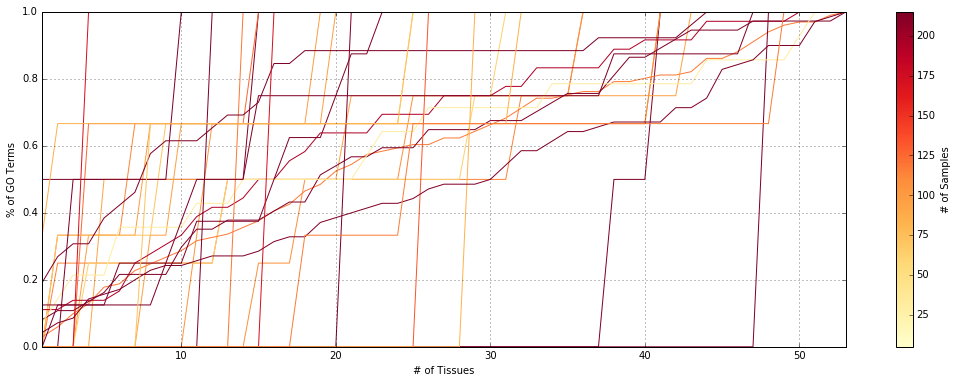

In [25]:
plot_emp_cdf(aucs, all_tissues, GO_terms, sample_counts, '# of Samples', hmap_normalization=2,
            tissue_specific_GO=True, gtex_to_go_map=GTEX_to_GO)

## Now Highlight "Special" Tissues

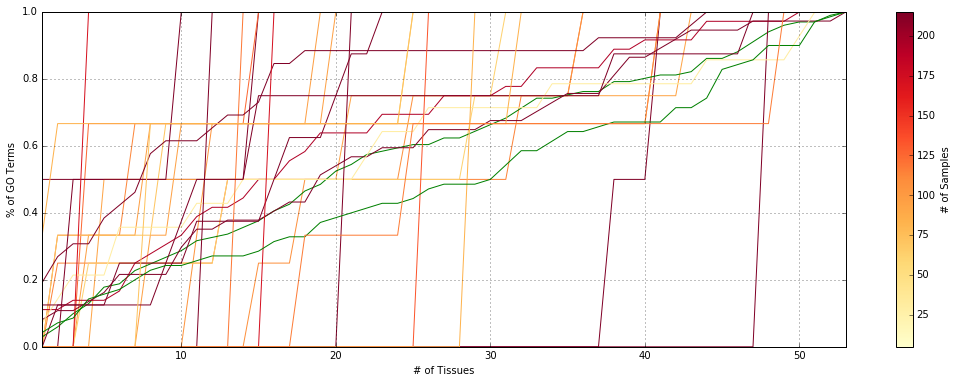

Highlighted tissues:  Cells - EBV-transformed lymphocytes, Whole Blood


In [26]:
plot_emp_cdf(aucs, all_tissues, GO_terms, sample_counts, '# of Samples', hmap_normalization=2,
            special_tissues=special_tissues, tissue_specific_GO=True, gtex_to_go_map=GTEX_to_GO)

## "CDF" Curves Version 2. Ex: For X% of ALL GO terms, blood features are in the top N AUC Scores.

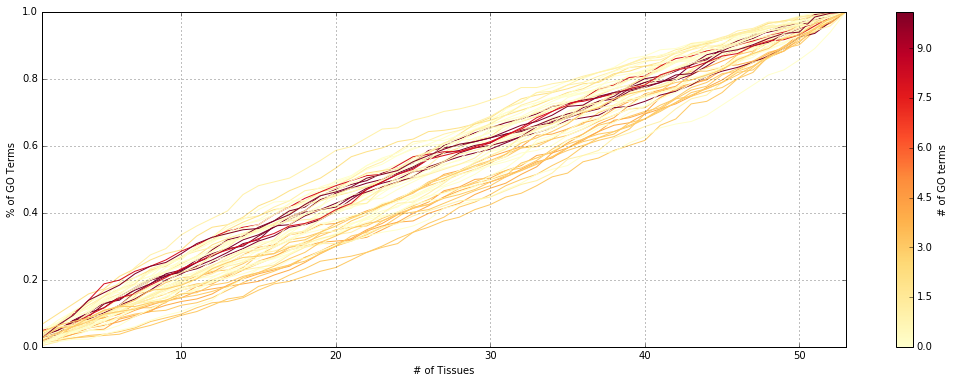

In [27]:
plot_emp_cdf(aucs, all_tissues, GO_terms, GO_counts, '# of GO terms', hmap_normalization=10)

## Same Curve as Above but colored by samples

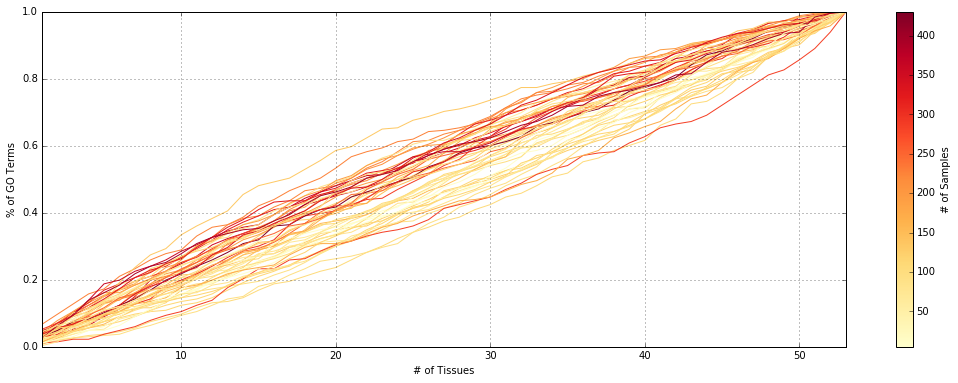

In [28]:
plot_emp_cdf(aucs, all_tissues, GO_terms, sample_counts, '# of Samples', hmap_normalization=1)

## Color By Samples as Above. Also Highlight "Special" Tissues

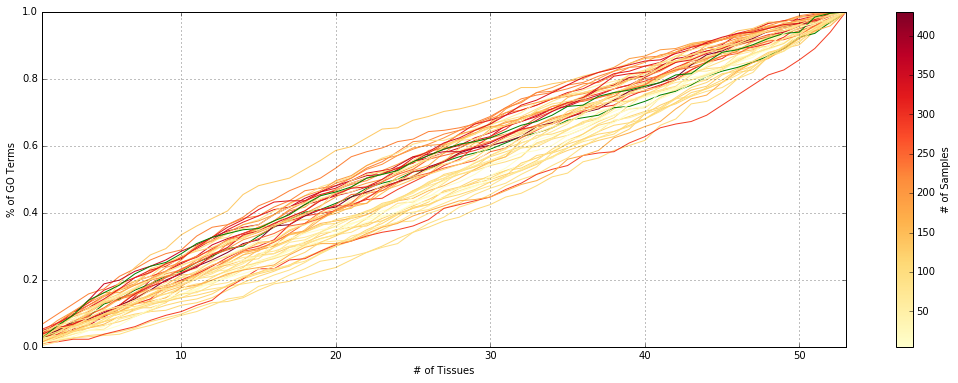

Highlighted tissues:  Cells - EBV-transformed lymphocytes, Whole Blood


In [29]:
plot_emp_cdf(aucs, all_tissues, GO_terms, sample_counts, '# of Samples', hmap_normalization=1,
            special_tissues=special_tissues)

## (NOTE: this section is not yet complete. I probably won't complete it b/c the above cdf curves contain more info). 

Generate stacked bar plot. Each tissue should have a stack. The top of the nth stack represents the fraction of the time that this tissue was among the nth best predictors for a GO term that is annoted with this tissue.

In [ ]:
num_stacks = 3
mat = np.zeros(shape=())

In [ ]:
# For each GO term, generate a list of tissues in order of their AUC scores for this GO term
GO_best_predictors = {}
for term in GO_terms:
    aucs = get_1_tissue_aucs(term, tissues_sorted)
    best_tissue_idxs = np.argsort(aucs)[::-1]
    GO_best_predictors[term] = np.array(tissues_sorted)[best_tissue_idxs[0:num_stacks]]

In [ ]:
num_stacks = 3
aucs_sorted_top3 = np.zeros(shape=(len(tissues_sorted), num_stacks))

# For each tissue, determine fraction of time it results in a top AUC score for its 
# associated GO terms
for (i, tissue) in enumerate(tissues_sorted):
    GO_assoc = GTEXmap[tissue] # associated GO terms
    fracs = np.zeros(shape=(1, num_stacks))
    for term in GO_assoc:
        # TODO: figure out why some terms in GO_assoc are not in GO_best_predictors
        if term in GO_best_predictors:
            top_tissues = GO_best_predictors[term][0:num_stacks]
            if tissue in top_tissues:
                tiss_index = np.where(top_tissues == tissue) #top_tissues.index(tissue)
                fracs[0, tiss_index] += 1
    fracs *= (1.0 / len(GO_assoc))
    aucs_sorted_top3[i, :] = fracs

plt.figure(figsize=(18, 6))
ax = plt.gca()
idx = range(0, len(tissues_sorted))
width = 0.3
# colors
colors = ['red', 'blue', 'green']
for (i, row) in enumerate(np.transpose(aucs_sorted_top3)):
    if i==0:
        ax.bar(idx, row, width, color=colors[i])
    else:
        ax.bar(idx, row, width, color=colors[i],
             bottom=prev_top)
    prev_top = row

plt.xticks(range(len(tissues_sorted)), tissues_sorted, rotation='vertical')
ax.set_xticks(np.arange(len(tissues_sorted)) + 0.3/2.)
plt.show()

In [ ]:
# Why does this get an AUC of 1 ??
#  GO:0033561 using only skin sun exposed
labels_ = [0, 1, 1, 0, 0, 1, 0, 0, 1]
p_prob = [0.000384567351229, 0.999999999702, 0.999998206652, 0.159726368778, 0.192961997394, 0.472920036517, 0.0170798368776, 0.0291811896014, 0.999999999327]
print roc_auc_score(labels_, p_prob)

cur_fpr, cur_tpr, _ = roc_curve(labels_, p_prob)
        
plt.plot(cur_fpr, cur_tpr, 'gray')
plt.plot([0, 1], [0, 1], 'k--')  # Plot the 50% line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
range(0,4)

In [ ]:
import itertools
li1 = [1, 2]
li2 = [3, 4]
li = [li1, li2]
hyp_combos = list(itertools.product(*li))
print hyp_combos
sharpe_ratios = [1, 2, 3, 4]
best_window, best_eps = hyp_combos[sharpe_ratios.index(max(sharpe_ratios))]
print best_window
print best_eps